# A record of generation variables for different models in the database folder

In [15]:
import numpy as np
import pyvista as pv

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv
from structgeo.data.file_manager import FileManager

import importlib

pv.set_jupyter_backend('static')

In [16]:
def reloader():
    importlib.reload(geo)
    importlib.reload(geovis)
    importlib.reload(geohistory)
    importlib.reload(rv)
reloader()

## Goal:
Make an interaface that will present generated models with a yes/no decision to save the model

In [17]:
# Set random seed for reproducibility
# random_seed = 1234
# np.random.seed(random_seed)


Loading models from ../database/sedimentary_plane


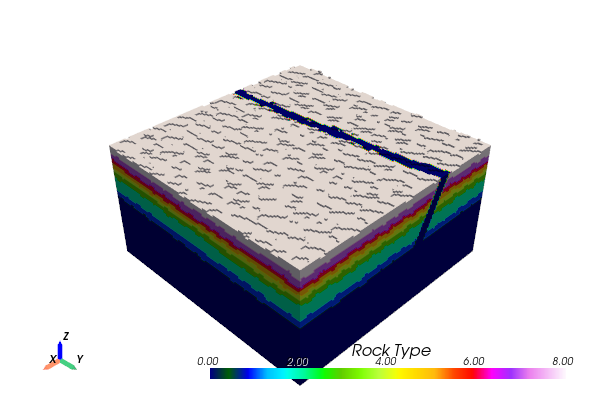

In [18]:
from structgeo.data.file_manager import FileManager

# Display the last saved model
fm = FileManager("../database/sedimentary_plane")
models = fm.load_all_models()
model = models[-1]
model.compute_model()
geovis.volview(model).show(window_size=[600, 400])

## Sedimentary Plane

In [19]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/sedimentary_plane"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 15)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(height, list(range(1, 100)), thickness_callable=thickness)
    
    # Add micro fold noise to the model
    def fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .18),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(30, 60),
            'amplitude': np.random.uniform(1.2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]

    model.clear_history()
    model.add_history([bedrock, sediment] + sediment_noise + geo_noise)
    model.compute_model()
    return model


reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Model created with bounds (-10, 10) and resolution 128


Output()

# Sedimentary Plane with Dikes

In [20]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/sedimentary_plane_dikes"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 15)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(height, list(range(1, 100)), thickness_callable=thickness)
    
    # Add micro fold noise to the model
    def fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .08),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    
    # Recover the last layer of rock
    model.clear_history()
    model.add_history([bedrock, sediment])
    model.compute_model()
    model.clear_data()
    last_val = sediment.values_sequence_used[-1]

    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(30, 60),
            'amplitude': np.random.uniform(1.2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]


    n_dikes = 2
    dike_rock_val = last_val+1
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.05, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
    params = dike_params()
    dike1 = geo.Dike(**params)
    
    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}
    
    additional_dikes = []
    for i in range(n_dikes-1):
        width = params['width']
        dike_gap = (i+1)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        additional_dikes.append(geo.Dike(**params))
        
    model.add_history(sediment_noise + geo_noise  + [dike1]+ additional_dikes )
    model.compute_model()
    return model

Model created with bounds (-10, 10) and resolution 128


In [21]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Strike: 181.93109594429833
Gap direction: [-1.25785297  0.04241071  0.        ]


Output()

### Tilted Sedimentary Planes, with and without Dikes

In [22]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/tilted_sedimentary_plane_vardikes"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")


def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 15)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(height, list(range(1, 100)), thickness_callable=thickness)
    
    # Add micro fold noise to the model
    def fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .08),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    
    # Recover the last layer of rock
    model.clear_history()
    model.add_history([bedrock, sediment])
    model.compute_model()
    model.clear_data()
    last_val = sediment.values_sequence_used[-1]

    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(15, 60),
            'amplitude': np.random.uniform(4),
            'periodic_func': rv.fourier_series_wave(num_harmonics=3),
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]

    n_dikes = 0
    dike_rock_val = last_val+1
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.05, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
    params = dike_params()
    
    dike1 = [geo.Dike(**params)] if n_dikes > 0 else []

    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}
    
    additional_dikes = []
    for i in range(n_dikes-1):
        width = params['width']
        dike_gap = (i+1)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        additional_dikes.append(geo.Dike(**params))
     
    tilt_params = {
        'strike': np.random.uniform(0, 360),
        'dip': np.random.uniform(0, 30),
    }    
    tilt = geo.Tilt(**tilt_params)
    
    model.clear_history()    
    model.add_history([bedrock]+ dike1+ additional_dikes + [sediment] +  sediment_noise + geo_noise + [tilt] )
    model.compute_model()
    return model

Model created with bounds (-10, 10) and resolution 128


In [23]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Output()

### Second Sedimentation

In [63]:
from structgeo.data.model_reviewer import ModelReviewer

DEFAULT_BASE_DIR = "../database/second_sedimenation"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

# Start rock vals from 5 to give space for adding dikes without knowing sedimentation values
def generate_model():
    START_ROCK_VAL = 3
    next_rock_val = START_ROCK_VAL
    # Place the model generation logic here
    base = min_x + np.random.normal(1, 1)
    height = base + 2 + np.random.normal(1, 1)
    
    def thickness():
        avg_thickness = (height-base)/np.random.uniform(2, 8)
        return np.random.lognormal(np.log(avg_thickness), .2)
    
    bedrock = geo.Bedrock(base, next_rock_val)
    next_rock_val += 1
    sediment = geo.SedimentationDeterministic(list(range(next_rock_val, next_rock_val+5)), thickness_callable=thickness)   
     
    # Recover the last layer of rock
    model.clear_history()
    model.add_history([bedrock, sediment])
    model.compute_model()
    model.clear_data()
    next_rock_val = sediment.values_sequence_used[-1] + 1
    
    # Add micro fold noise to the model
    def noise_fold_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.02, .1),
            'periodic_func': rv.fourier_series_wave(num_harmonics=5)
        }
    sediment_noise = [geo.Fold(**noise_fold_params()) for _ in range(np.random.randint(3, 7))]
    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(10, 60),
            'amplitude': np.random.uniform(1,2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]
    
    tilt_params = {
        'strike': np.random.uniform(0, 360),
        'dip': np.random.uniform(0, 30),
    }    
    tilt = geo.Tilt(**tilt_params)
    
    # Second Sedimentation
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
    
    def thickness2():
        avg_thickness = (height-base)/np.random.uniform(2, 8)
        return np.random.lognormal(np.log(avg_thickness), .1)
    
    nlayers = np.random.randint(4,10)
    sediment2 = geo.SedimentationDeterministic(list(range(next_rock_val, next_rock_val+nlayers)), thickness_callable=thickness2) 
    next_rock_val += nlayers    
        
    sediment_noise2 = [geo.Fold(**noise_fold_params()) for _ in range(np.random.randint(3, 4))]
    geo_noise2 = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]
    
    # Start at 0 
    dike_rock_val = START_ROCK_VAL - 1
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.5, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
        
    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}   
    
    n_dikes = 0
    params = dike_params()
    dikes = []    
    for i in range(n_dikes):
        width = params['width']
        dike_gap = (i)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        dikes.append(geo.Dike(**params))

    model.clear_history()
    model.add_history([bedrock, sediment]  + geo_noise + [tilt] + [sediment2] + geo_noise2 + dikes + sediment_noise2 )

    model.compute_model()
    return model


Model created with bounds (-10, 10) and resolution 128


In [64]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Output()

Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model discarded.


Model saved to ../database/second_sedimenation\model_104.pkl


In [26]:
import numpy as np
import pyvista as pv
import copy
import itertools

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv
from structgeo.data.file_manager import FileManager
from structgeo.data.model_reviewer import ModelReviewer

LOAD_FOLDER = "../database"
DEFAULT_BASE_DIR = "../augmented_sediment_models"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

# Load an existing model from file
models = FileManager(LOAD_FOLDER).load_all_models()
    # Select a random model from the loaded models and make a deep copy
model_cycler = itertools.cycle(models[170:-1])

def generate_model():

    model = copy.deepcopy(next(model_cycler))
    rotation_axis = (np.random.uniform(0,.15) ,np.random.uniform(0,.15),1)
    rotation_amount = np.random.uniform(0, 360)
    rotate = geo.Rotate(rotation_axis, rotation_amount)
    # make a random 3D shift vector
    shift_vector = (np.random.normal(0,3), np.random.normal(0,3), np.random.normal(0,3))
    shift = geo.Shift(shift_vector)
    model.add_history([rotate, shift])
    model.compute_model()
    bounds = model.get_z_bounds()
    zmin, zmax = bounds
    z_range = zmax - zmin
    target_height = zmin + z_range*np.random.normal(.8, .05)    
    print(f"Target height: {target_height}")
    model.renormalize_height(target_height)
    return model

model = generate_model()


Model created with bounds (-10, 10) and resolution 128
Loading models from ../database
Loading models from ../database\augmented_sediment_models
Loading models from ../database\second_sedimenation
Loading models from ../database\sedimentary_plane
Loading models from ../database\sedimentary_plane_dikes
Loading models from ../database\tilted_sedimentary_plane_vardikes
Target height: 6.110413279210583


In [27]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Target height: 5.133295176348065


Output()

# Add fault/ shear/ slip

Loading models from ../database
Loading models from ../database\augmented_sediment_models
Loading models from ../database\second_sedimenation
Loading models from ../database\sedimentary_plane
Loading models from ../database\sedimentary_plane_dikes
Loading models from ../database\tilted_sedimentary_plane_vardikes
Target height: 6.37


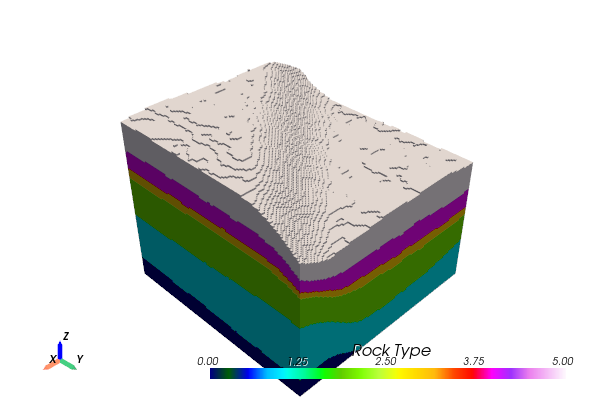

In [36]:
import numpy as np
import pyvista as pv
import copy
import random

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv
from structgeo.data.file_manager import FileManager
from structgeo.data.model_reviewer import ModelReviewer
pv.set_jupyter_backend('static')

LOAD_FOLDER = "../database"
DEFAULT_BASE_DIR = "../sheared_models"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)

# Load an existing model from file
models = FileManager(LOAD_FOLDER).load_all_models()

# Single model loader
#models = FileManager("../faulted_models").load_all_models()

# Select a random model from the loaded models and make a deep copy
model = np.random.choice(models)
demo_model = models

def get_history():
    """ Make an appended slip based history to add"""

    def fault_sequence(n_faults):
        # Random fault line
        strike = np.random.uniform(0, 360)
        dip = np.random.normal(80,20)
        rake = np.random.uniform(0, 180)
        amplitude = np.random.normal(1,1)
        origin = rv.random_point_in_ellipsoid(model.bounds)    
        strike_radians = np.deg2rad(strike)
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0])
        
        def parameters():
            params = {
            'strike': strike + np.random.normal(0, 5),
            'dip': dip + np.random.normal(0, 5),
            'rake': rake + np.random.uniform(0, 7),
            'amplitude': amplitude + np.random.normal(0, .2),
            'steepness': np.random.normal(3,1),
            'origin': origin + np.random.normal(.2, .2)*gap_dir,
        }
            return params
    
        faults = []
        for _ in range(n_faults):
            params = parameters()
            faults.append(geo.Shear(**params))            
        return faults
    
    n_faults = 1
    return fault_sequence(n_faults)

def generate_model():
    # Select a random model from the loaded models and make a deep copy
    demo_model = np.random.choice(models)
    model = copy.deepcopy(demo_model)   
    
    # Shuffle the view a bit
    rotation_axis = (np.random.uniform(0,.05) ,np.random.uniform(0,.05),1)
    rotation_amount = np.random.uniform(0, 360)
    rotate = geo.Rotate(rotation_axis, rotation_amount)
    shift_vector = (np.random.normal(0,1), np.random.normal(0,1), np.random.normal(0,1))
    shift = geo.Shift(shift_vector)
    model.add_history([rotate, shift])
    
    # Add some fault history
    model.add_history(get_history())
    model.compute_model()
    model.renormalize_height(auto = True)
    return model

model = generate_model()

geovis.volview(model).show(window_size=[600, 400])

In [37]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Target height: 5.47


Output()

Model saved to ../sheared_models\model_36.pkl


Model discarded.
Target height: 5.71


Model discarded.
Target height: 6.13


Model discarded.
Target height: 5.81


0.008702953


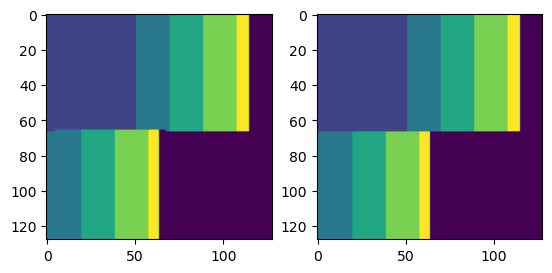

In [61]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from structgeo.model import geo
import structgeo.plot as geovis
from structgeo.model import history as geohistory
import structgeo.probability as rv
from structgeo.data.file_manager import FileManager
from structgeo.data.model_reviewer import ModelReviewer
pv.set_jupyter_backend('static')

LOAD_FOLDER = "../database"
DEFAULT_BASE_DIR = "../faulted_models"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)

def generate_model():
    # Bedrock layer
    bedrock = geo.Bedrock(-5, 0)
    sediment = geo.Sedimentation(5,range(1,100), thickness_callable=lambda: 3)
    fault = geo.Fault(strike=190, dip=90, rake=45, amplitude=2, origin=(1,1,1))
    fold = geo.Fold(strike = 45, dip = 80, rake=45, period=5 , amplitude= .2,)
    
    model.add_history([bedrock, sediment,  fault, fold])
    model.compute_model()
    return model


# Bedrock layer
bedrock = geo.Bedrock(-5, 0)
sediment = geo.Sedimentation(5,range(1,100), thickness_callable=lambda: 3)
fault = geo.Fault(strike=190, dip=90, rake=0, amplitude=2, origin=(1,1,1))
fold = geo.Fold(strike = 45, dip = 80, rake=0, period=5 , amplitude= .2,)

model1 = geo.GeoModel(bounds, resolution)
model2 = geo.GeoModel(bounds, resolution)
model1.add_history([bedrock, sediment,  fault, fold])
model2.add_history([bedrock, sediment,  fold,fault])

models = [model1, model2]
for m in models:
    m.compute_model()
    m.fill_nans(-1)

values1 = model1.data.reshape(model1.X.shape)
plt.subplot(1,2,1)
plt.imshow(values1[:,50,:], cmap='viridis')

values2 = model2.data.reshape(model2.X.shape)
plt.subplot(1,2,2)
plt.imshow(values2[:,50,:], cmap='viridis')

print(np.sum((values2-values1)**2)/np.sum((values2)**2))




In [62]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Output()